In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current cuda device is', device)

batch_size = 50
learning_rate = 0.0001
epoch_num = 15

train_data = datasets.MNIST(root = '../data/mnist/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = '../data/mnist/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

Current cuda device is cuda
number of training data :  60000
number of test data :  10000


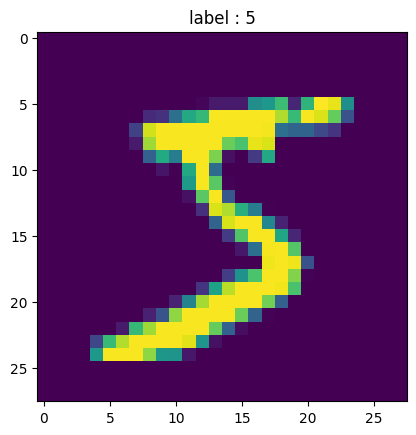

In [2]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy())#, cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [41]:
# train_data
# let's PCA the data

# making dataset as m ,n matrix

type(train_data[0][0]),train_data[0][0].shape
# making dataset as m ,n matrix
# resize the image to 1D

Data_dist = []
for i in range(1000):
    
    a = train_data[i][0].view(-1)
    Data_dist.append(a)
data = torch.stack(Data_dist)
type(data),data.shape

xtx = (data.T)@data
print(xtx.shape)

torch.Size([784, 784])


In [54]:

def PCA(data, k):
    xtx = (data.T)@data
    
    # xtx = xtx.to(torch.complex128)
    # eigenvalue decomposition      
    L,V = torch.linalg.eig(xtx)# eigenvale lambda, eigenvector V
    torch.dist(V @ torch.diag(L) @ torch.linalg.inv(V) , xtx)
    # sort eigenvalue and eigenvector
    L = L.real
    D = torch.diag(L)
    data_reduced = V[:,:k] @ torch.sqrt(D[:k,:k])
    # data@data^T = V@D@V^T
    # U = data@V@D^(-1/2)
    
    
    

In [56]:
L.shape,V.shape

(torch.Size([784]), torch.Size([784, 784]))

In [67]:
D = torch.diag(L)

# U = data @ V @ torch.linalg.inv(D)

# U = U.to(torch.complex128)
# torch.dist(U.T @ U , torch.eye(784))a
# U.shape

In [68]:

Data_dist = []
for i in range(1000):
    
    a = train_data[i][0].view(-1)
    Data_dist.append(a)
data = torch.stack(Data_dist)

In [71]:
data = data.to(torch.float64) //255.0

# subtract mean
data = data - torch.mean(data,0)



torch.Size([1000, 784])

In [65]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the MNIST dataset
# mnist = datasets.MNIST(root=".", train=False, download=True, transform=transforms.ToTensor())
mnist = train_data

# Standardize the data
data = mnist.data.float() / 255.0

# Perform PCA
# pca = transforms.PCA(n_components=2)
pca = torch.pca_lowrank(data, q=2)
# pca.fit(data)

# # Get the principal components
# components = pca.components_

# # Plot the principal components
# plt.scatter(components[:, 0].numpy(), components[:, 1].numpy(), c=mnist.targets)
# plt.show()
type(pca)#,pca.shape
len(pca)
pca[0].shape,pca[1].shape,pca[2].shape

(torch.Size([60000, 28, 2]),
 torch.Size([60000, 2]),
 torch.Size([60000, 28, 2]))

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)
first_batch = train_loader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(3136, 1000)    # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
        i += 1

Train Step : 1000	Loss : 0.159432
Train Step : 2000	Loss : 0.027097
Train Step : 3000	Loss : 0.026924
Train Step : 4000	Loss : 0.127474
Train Step : 5000	Loss : 0.030939


KeyboardInterrupt: 